In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import time

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
image_dataset = ImageFolder(path, transform,)
train_size = int(0.75*len(image_dataset))
test_size = len(image_dataset)-train_size
train_data, test_data = random_split(image_dataset, [train_size, test_size])
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=False, batch_size=32)

This project is compute intensive. If you have a mps or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


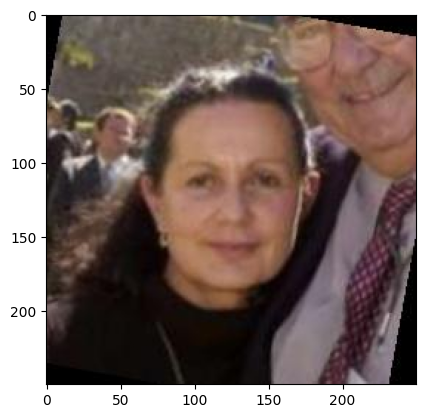

In [5]:
for x,y in train_loader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x, _ in train_loader:
    x = x.to("mps")
    print(x.device)
    break

mps:0


In [7]:
print(x.shape)

torch.Size([32, 3, 250, 250])


The dimension of the data is 32 by 3 by 250 by 250. The 32 is the batch size of the data. 3 is the 3 color channel. The two 250 are the height and width dimension of the image.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In this model we will use Conv2d, MaxPool2d, and ReLU for the encoder part. For the decoder part, we will use ConvTranspose2d, ReLU, Conv2d, and Sigmoid.

In [8]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.enc_activation1 = nn.ReLU()
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.enc_activation2 = nn.ReLU()
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.enc_activation3 = nn.ReLU()
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # Decoder layers
        self.dec_convtrans1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_activation1 = nn.ReLU()
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dec_activation2 = nn.ReLU()
        self.dec_convtrans2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1) 
        self.dec_activation3 = nn.ReLU()
        self.dec_conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dec_activation4 = nn.ReLU()
        self.dec_convtrans3 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2, padding=1) 
        self.dec_activation5 = nn.Sigmoid()

    def encoder(self, x):
        layer1 = self.enc_activation1(self.enc_conv1(x))
        layer2 = self.enc_pool1(layer1)
        layer3 = self.enc_activation2(self.enc_conv2(layer2))
        layer4 = self.enc_pool2(layer3)
        layer5 = self.enc_activation3(self.enc_conv3(layer4))
        out = self.enc_pool3(layer5)
        return out

    def decoder(self, x):
        layer1 = self.dec_activation1(self.dec_convtrans1(x))
        layer2 = self.dec_activation2(self.dec_conv1(layer1))
        layer3 = self.dec_activation3(self.dec_convtrans2(layer2))
        layer4 = self.dec_activation4(self.dec_conv2(layer3))
        out = self.dec_activation5(self.dec_convtrans3(layer4))
        return out

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

# Instantiate the model
auto = AE()

# Calculate the number of parameters
total_params = sum(p.numel() for p in auto.parameters() if p.requires_grad)

total_params

235139

In [9]:
autoencoder = AE()

In [10]:
autoencoder.to("mps")

AE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation1): ReLU()
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation2): ReLU()
  (enc_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation3): ReLU()
  (enc_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_convtrans1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation1): ReLU()
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_activation2): ReLU()
  (dec_convtrans2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation3): ReLU

In [11]:
next(autoencoder.parameters()).device

device(type='mps', index=0)

In [12]:
encoded = autoencoder.encoder(x)

In [13]:
print(encoded.shape)

torch.Size([32, 128, 31, 31])


In [14]:
print(autoencoder.decoder(encoded).shape)

torch.Size([32, 3, 250, 250])


In [15]:
pytorch_total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

In [16]:
print(pytorch_total_params)

235139


In [17]:
y = autoencoder.decoder(encoded)

In [18]:
y = y.cpu()

In [19]:
y = y[0].permute(1, 2, 0)

In [20]:
print(y.shape)

torch.Size([250, 250, 3])


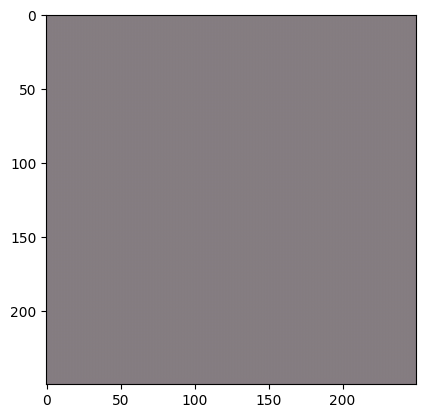

In [21]:
plt.imshow(y.detach().numpy())

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

Let initialize our model by calling the constructor on AE and assign it to model

In [22]:
model = AE()

Next we will move our model into GPU for faster training since it is available to us.

In [23]:
model.to("mps")

AE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation1): ReLU()
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation2): ReLU()
  (enc_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_activation3): ReLU()
  (enc_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec_convtrans1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation1): ReLU()
  (dec_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_activation2): ReLU()
  (dec_convtrans2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_activation3): ReLU

Let's encode our input and print out the shape.

In [24]:
encoded = model.encoder(x)
print(encoded.shape)

torch.Size([32, 128, 31, 31])


We can see that our input has been reduced from 3 by 250 by 250 to 128 by 31 by 31 through our encoder. Next let use the encoded data and put it through the decoder to make sure that it decodes the data back to the right size which is 3 by 250 by 250. The number 32 should stay the same since it is the batch size.

In [25]:
decoded = model.decoder(encoded)
print(decoded.shape)

torch.Size([32, 3, 250, 250])


This confirm that we the model work correctly as we wanted it to.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

This code was borrow from stack overflow. Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

In [26]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(total_params)

235139


In [27]:
optim = torch.optim.Adam(model.parameters(), lr=0.0005)

Since we are trying to minimize the different between the input image X and the reconstructed image X', we are going to use MSELoss as our loss function.

In [28]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

Let define a function that will train the model for one epoch and report the average loss in that epoch for us.

In [29]:
def time_elapse(start):
    result = time.time()-start
    hours = int(result // 3600)
    minutes = int((result % 3600) // 60)
    seconds = result % 60
    return f"{hours}h:{minutes}m:{seconds:.2f}s"

In [30]:
def train_one_epoch(start_time):
    last_loss = 0
    for i, data in enumerate(train_loader):
        inputs = data[0]
        inputs = inputs.to("mps")
        optim.zero_grad()
        outputs = model.forward(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optim.step()
        running_loss = loss.item()
        print(" Batch {} loss: {} Time elapsed: {}".format(i+1, running_loss, time_elapse(start_time)))
        last_loss += running_loss
    avg_train_loss = last_loss/(i+1)
    return avg_train_loss
    

In [31]:
epoch_number = 0
EPOCHS = 50
time_start = time.time()
for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number+1))
    model.train(True)
    avg_train_loss = train_one_epoch(time_start)
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            test_inputs = test_data[0]
            test_inputs = test_inputs.to("mps")
            test_outputs = model.forward(test_inputs)
            test_loss = loss_function(test_outputs, test_inputs)
            running_test_loss += test_loss
            print(" Batch {} test loss: {} Time elapsed: {}".format(i+1, test_loss, time_elapse(time_start)))
    avg_test_loss = running_test_loss/(i+1)
    print(" Average train loss: {}".format(avg_train_loss))
    print(" Average test loss: {}".format(avg_test_loss))
    epoch_number += 1

EPOCH 1:
 Batch 1 loss: 0.09885262697935104 Time elapsed: 0h:0m:1.78s
 Batch 2 loss: 0.1014564260840416 Time elapsed: 0h:0m:1.96s
 Batch 3 loss: 0.09792426973581314 Time elapsed: 0h:0m:2.12s
 Batch 4 loss: 0.09297210723161697 Time elapsed: 0h:0m:2.27s
 Batch 5 loss: 0.08946727216243744 Time elapsed: 0h:0m:2.42s
 Batch 6 loss: 0.09927936643362045 Time elapsed: 0h:0m:2.58s
 Batch 7 loss: 0.08869189769029617 Time elapsed: 0h:0m:2.74s
 Batch 8 loss: 0.08890821784734726 Time elapsed: 0h:0m:2.90s
 Batch 9 loss: 0.08990047127008438 Time elapsed: 0h:0m:3.05s
 Batch 10 loss: 0.09046199917793274 Time elapsed: 0h:0m:3.20s
 Batch 11 loss: 0.09998095780611038 Time elapsed: 0h:0m:3.36s
 Batch 12 loss: 0.08827591687440872 Time elapsed: 0h:0m:3.52s
 Batch 13 loss: 0.09438110142946243 Time elapsed: 0h:0m:3.68s
 Batch 14 loss: 0.0890030488371849 Time elapsed: 0h:0m:3.83s
 Batch 15 loss: 0.09169972687959671 Time elapsed: 0h:0m:3.99s
 Batch 16 loss: 0.08629439771175385 Time elapsed: 0h:0m:4.15s
 Batch 17 

In [32]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [33]:
model.load_state_dict(torch.load('model_state_dict.pth'))

<All keys matched successfully>

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [102]:
for _, x in enumerate(test_loader):
    print(x[0][4].shape)
    x_input = x[0][4]
    x = x[0][4].permute(1, 2, 0)
    break

torch.Size([3, 250, 250])


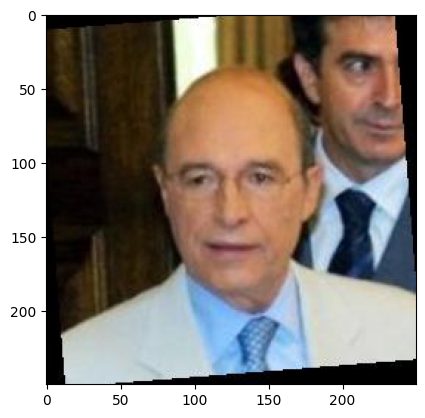

In [103]:
plt.imshow(x)

In [104]:
x_input = x_input.to("mps")

In [105]:
x_input.shape

torch.Size([3, 250, 250])

In [106]:
x_input = x_input.unsqueeze(0)

In [107]:
x_prime = model.forward(x_input)

In [108]:
encoded = model.encoder(x_input)

In [109]:
encoded.shape

torch.Size([1, 128, 31, 31])

In [110]:
average_encoded = torch.mean(encoded.squeeze(), dim=0)

In [111]:
average_encoded.shape

torch.Size([31, 31])

In [112]:
average_encoded = average_encoded.cpu()

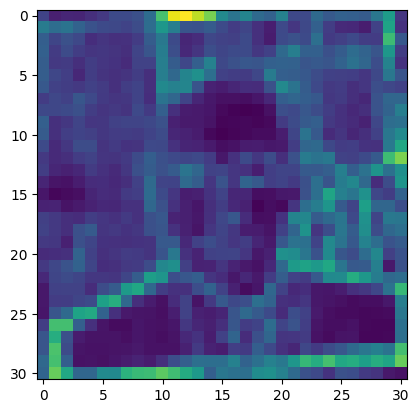

In [113]:
plt.imshow(average_encoded.detach().numpy())

In [114]:
encoded = encoded.cpu()

In [115]:
encoded_0 = encoded[0,2]

In [116]:
encoded_0.shape
encoded_0 = encoded_0.cpu()

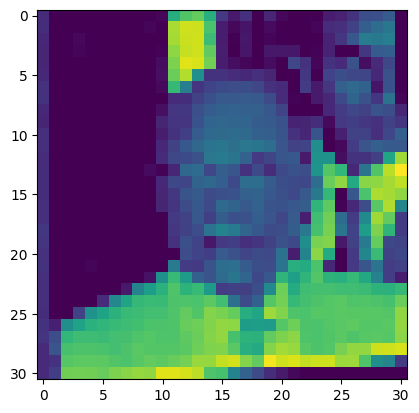

In [117]:
plt.imshow(encoded_0.detach().numpy())

In [118]:
x_prime = x_prime.squeeze()

In [119]:
x_prime.shape

torch.Size([3, 250, 250])

In [120]:
x_prime = x_prime.permute(1, 2, 0)

In [121]:
x_prime = x_prime.cpu()

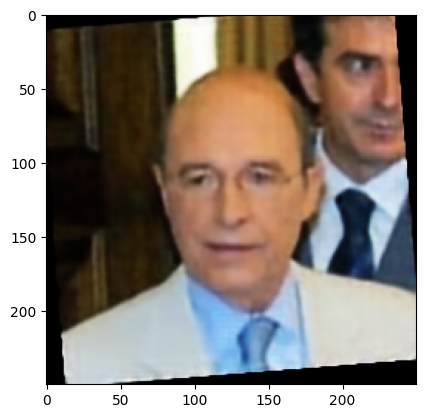

In [122]:
plt.imshow(x_prime.detach().numpy())

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [123]:
encoded = encoded.to("mps")

In [124]:
encoded = encoded+(torch.rand_like(encoded))

In [125]:
encoded.shape

torch.Size([1, 128, 31, 31])

In [126]:
average_encoded = torch.mean(encoded.squeeze(), dim=0)
average_encoded.shape

torch.Size([31, 31])

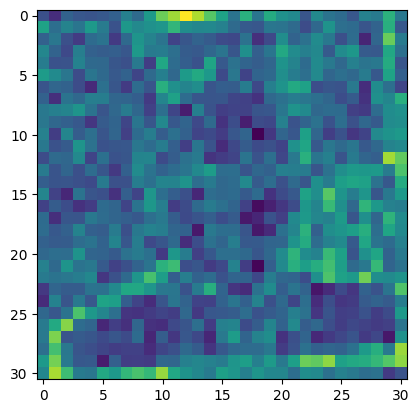

In [127]:
average_encoded = average_encoded.cpu()
plt.imshow(average_encoded.detach().numpy())

In [128]:
encoded.shape
decoded_noise = model.decoder(encoded)

In [129]:
decoded_noise = decoded_noise.squeeze()
decoded_noise.shape

torch.Size([3, 250, 250])

In [130]:
decoded_noise = decoded_noise.permute(1, 2, 0)

Code from Fall-23-APML-Public/Tutorials/AE.ipynb

In [133]:
def plot_image_pair(x,y):
    plt.subplot(121)
    plt.imshow(x.detach().cpu().squeeze())
    plt.subplot(122)
    plt.imshow(y.detach().cpu().squeeze())

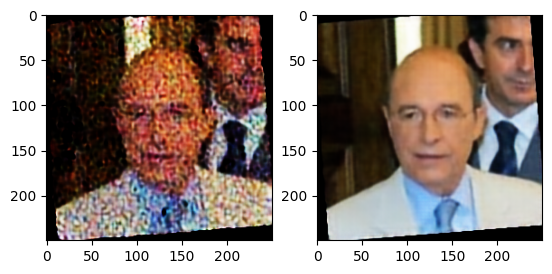

In [135]:
decoded_noise = decoded_noise.cpu()
plot_image_pair(decoded_noise, x_prime)